In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import joblib

In [ ]:
df_pretraited = pd.read_csv("dataPreprocessed.csv", low_memory=False)
df_pretraited.head()

,normality,sourceID_freq,accessed_addr_freq,src_dest_same_addr,src_dest_same_type,src_dest_same_loc,value_movement,value_tempin,value_lightOn,value_heatingcontrol,...,value_movement_present,value_lightOn_present,value_heatingcontrol_present,acc_node_event_present,hour_sin,hour_cos,delta_time,events_per_min,is_night,is_work_hours
0,0,0.040505,0.000003,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,0,-0.258819,0.965926,-0.072967,0.209502,0,0
1,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,0.220811,0.274155,0,0
2,0,0.040505,0.018952,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.028332,0.274155,0,0
3,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.054648,0.274155,0,0
4,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.072456,0.274155,0,0


## Partie1: Exploration des Donnees

#### Split des donnees

In [ ]:
# X = tes features, y = ta target (0=normal, 1=anomalie)
X = df_pretraited.copy()
X = X.drop(columns=['normality'])
y = df_pretraited['normality']


# Split train+val et test (80%-20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Split train et validation (80%-20% du train+val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

print("Train:", len(X_train), "Validation:", len(X_val), "Test:", len(X_test))

Train: 229088 Validation: 57273 Test: 71591


In [ ]:
print("Train (%):\n", y_train.value_counts(normalize=True) * 100)
print("\nValidation (%):\n", y_val.value_counts(normalize=True) * 100)
print("\nTest (%):\n", y_test.value_counts(normalize=True) * 100)

Train (%):
 normality
0    97.201512
1     2.798488
Name: proportion, dtype: float64

Validation (%):
 normality
0    97.201124
1     2.798876
Name: proportion, dtype: float64

Test (%):
 normality
0    97.202162
1     2.797838
Name: proportion, dtype: float64


### Model SVM (utilisons SVC)

In [ ]:
# Définition le modèle SVM
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# Entraînement sur le train
svm_model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [ ]:
joblib.dump(svm_model, "svm_model.pkl")

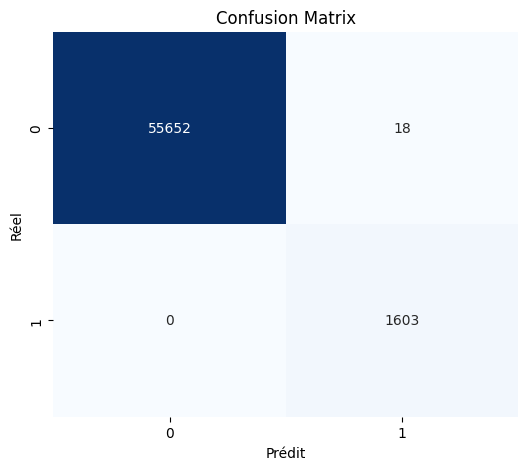

In [ ]:
svm_model = joblib.load("svm_model.pkl")
y_val_pred = svm_model.predict(X_val)
y_val_probs = svm_model.predict_proba(X_val)[:, 1]

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Confusion Matrix')
plt.show()

55652 : vrais négatifs (normaux correctement détectés)

18 : faux positifs (normaux classés comme anomalie)

0 : faux négatifs (anomalies manquées)

1603 : vrais positifs (anomalies correctement détectées)

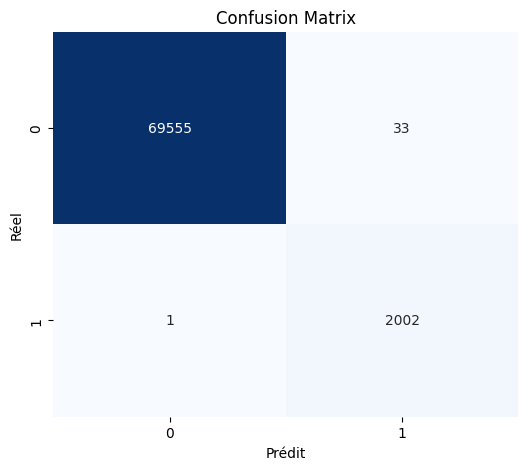

In [ ]:
y_test_pred = svm_model.predict(X_test)
y_test_probs = svm_model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Confusion Matrix')
plt.show()

69582 : vrais négatifs (normaux correctement détectés)

33 : faux positifs (normaux classés comme anomalie)

1 : faux négatifs (anomalies manquées)

2002 : vrais positifs (anomalies correctement détectées)

In [ ]:
# Rapport de classification
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_val, y_val_probs)
print("ROC-AUC:", roc_auc)

precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

pr_auc = average_precision_score(y_val, y_val_probs)
print("PR-AUC:", pr_auc)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     55670
           1       0.99      1.00      0.99      1603

    accuracy                           1.00     57273
   macro avg       0.99      1.00      1.00     57273
weighted avg       1.00      1.00      1.00     57273

ROC-AUC: 0.9998297605497865
PR-AUC: 0.98534825026789


In [ ]:
# Rapport de classification
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_test_probs)
print("ROC-AUC:", roc_auc)

precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)

pr_auc = average_precision_score(y_test, y_test_probs)
print("PR-AUC:", pr_auc)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     69588
           1       0.98      1.00      0.99      2003

    accuracy                           1.00     71591
   macro avg       0.99      1.00      1.00     71591
weighted avg       1.00      1.00      1.00     71591

ROC-AUC: 0.9997947085522202
PR-AUC: 0.9802769900167054
